In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append("..")

from cybb_mist.path_conf import interim_data_dir, processed_data_dir
from tqdm.auto import tqdm
import pandas as pd
from functional import seq
from cybb_mist.trigger_mapping import parse_trigger_series


## joining `df_trigger_tot` with `df_rr`

In [3]:
import hrvanalysis

In [4]:
r_list = []
for pqt in tqdm(sorted(list(interim_data_dir.rglob("*/SCL_*.parquet")))):
    try:
        patient_id = pqt.parent.name
        condition = pqt.name.split(".")[0].split("_")[-1]
        df_trigger = parse_trigger_series(pd.read_parquet(pqt)["trigger"])
        df_trigger["patient_id"] = patient_id
        df_trigger["condition"] = condition
        df_trigger["duration"] = df_trigger["t_end"] - df_trigger["t_start"]
        df_trigger["duration_s"] = df_trigger["duration"].dt.total_seconds()
        df_trigger = df_trigger.dropna().drop_duplicates(
            subset=["trigger"], keep="first"
        )

        p = list(processed_data_dir.joinpath(patient_id).glob(f"df_rr_{condition}.parquet"))
        if not len(p):
            print(f"skipping user: {patient_id} - no df_rr")
            continue
        df_rr = pd.read_parquet(p[0])

        min_r_peak_agreement_threshold = 0.8

        for _, r in df_trigger.iterrows():
            if r.duration_s + 10 < 300:
                print(
                    f"skipping slice:{r.patient_id} - {r.trigger} - duration ({r.duration}) too short"
                )
                continue

            # slc = df_rr[r.t_start : r.t_start + pd.Timedelta(minutes=5)]
            slc = df_rr[r.t_end - pd.Timedelta(seconds=400) : r.t_end]
            # do not use slices with lower
            mean_r_peak_agreement = slc["r_peak_agreement"].mean()

            rrs = hrvanalysis.remove_outliers(
                slc["RR_interval_ms"].dropna().values, verbose=False
            )

            if (
                mean_r_peak_agreement < min_r_peak_agreement_threshold
            ) or len(rrs) < 250:
                print(len(slc), len(slc.RR_interval_ms.dropna()), len(rrs))
                print(
                    f"skipping slice user - {r.patient_id} - {r.trigger} - "
                    "{len(slc)} - {mean_r_peak_agreement}"
                )
                continue

            r_list.append(
                pd.concat(
                    [
                        r,
                        pd.Series(hrvanalysis.get_time_domain_features(rrs)),
                        pd.Series(hrvanalysis.get_frequency_domain_features(rrs)),
                    ]
                )
            )

    except Exception as e:
        print(e)


  0%|          | 0/124 [00:00<?, ?it/s]

skipping user: 14 - no df_rr
114 114 114
skipping slice user - 16 - Start rest control (eyes open) - {len(slc)} - {mean_r_peak_agreement}
arange: cannot compute length
337 183 183
skipping slice user - 28 - Start rest baseline (eyes closed) - {len(slc)} - {mean_r_peak_agreement}
409 123 123
skipping slice user - 31 - Start rest baseline (eyes open) - {len(slc)} - {mean_r_peak_agreement}
214 0 0
skipping slice user - 31 - Start cyberball control - {len(slc)} - {mean_r_peak_agreement}
219 0 0
skipping slice user - 31 - Start rest control (eyes closed) - {len(slc)} - {mean_r_peak_agreement}
253 0 0
skipping slice user - 31 - Start rest control (eyes open) - {len(slc)} - {mean_r_peak_agreement}
186 0 0
skipping slice user - 31 - Start cyberball stress - {len(slc)} - {mean_r_peak_agreement}
0 0 0
skipping slice user - 31 - Start rest stress (eyes closed) - {len(slc)} - {mean_r_peak_agreement}
0 0 0
skipping slice user - 31 - Start rest stress (eyes open) - {len(slc)} - {mean_r_peak_agreemen

In [5]:
df_feat = pd.concat(r_list, axis=1).T

In [6]:
scl_list = []
for pqt in tqdm(sorted(list(interim_data_dir.rglob("*/SCL_*.parquet")))):
    try:
        patient_id = pqt.parent.name
        condition = pqt.name.split(".")[0].split("_")[-1]
        df_trigger = parse_trigger_series(pd.read_parquet(pqt)["trigger"])
        df_trigger["patient_id"] = patient_id
        df_trigger["condition"] = condition
        df_trigger["duration"] = df_trigger["t_end"] - df_trigger["t_start"]
        df_trigger["duration_s"] = df_trigger["duration"].dt.total_seconds()
        df_trigger = df_trigger.dropna().drop_duplicates(
            subset=["trigger"], keep="first"
        )

        p = list(
            processed_data_dir.joinpath(patient_id).glob(
                f"df_scl_proc_{condition}.parquet"
            )
        )
        if not len(p):
            print(f"skipping user: {patient_id} - no df_scl")
            continue
        df_scl = pd.read_parquet(p[0])

        min_SQI_threshold = 0.9

        for _, r in df_trigger.iterrows():
            if r.duration_s + 10 < 300:
                print(
                    f"skipping slice:{r.patient_id} - {r.trigger} - duration ({r.duration}) too short"
                )
                continue

            slc = df_scl[r.t_end - pd.Timedelta(seconds=400) : r.t_end]
            # do not use slices with lower
            mean_sqi = slc["EDA_SQI_smoothend"].mean()

            if mean_sqi < min_SQI_threshold:  # or len(rrs) < 300:
                # print(len(slc), len(slc.RR_interval_ms.dropna()), len(rrs))
                print(
                    f"skipping slice user - {r.patient_id} - {r.trigger} - "
                    f"{mean_sqi} - {min_SQI_threshold}"
                )
                continue

            scl_list.append(
                pd.concat(
                    [
                        r,
                        pd.Series(
                            {
                                # skin conductance responses per minute
                                "SCRR": slc["SCR_Peaks_scipy_reduced"].fillna(0).sum()
                                / 5,
                                "phasic_area": slc["EDA_Phasic"].mean(),
                                "tonic_mean": slc["EDA_lf_cleaned_tonic_lf"].mean(),
                                "phasic_area_normalized": slc[
                                    "EDA_lf_cleaned_tonic_lf"
                                ].mean(),
                                "mean_EDA_SQI": slc["EDA_SQI_smoothend"].mean(),
                            }
                        ),
                    ]
                )
            )

    except Exception as e:
        print(e)

    # break


  0%|          | 0/124 [00:00<?, ?it/s]

skipping user: 14 - no df_scl
skipping user: 41 - no df_scl


In [7]:
merge_cols = ["patient_id", "trigger", "condition"]
df_feat_tot = df_feat.merge(
    pd.concat(scl_list, axis=1).T.drop(
        columns=set(df_trigger.columns).difference(
            ["patient_id", "trigger", "condition"]
        )
    ),
    on=["patient_id", "trigger", "condition"],
    how="outer",
)


## Analyzing `df_feat`

In [8]:
import seaborn as sns

sns.set_context("talk")


In [9]:
df_feat_tot.melt(
        id_vars=[
            "t_start",
            "t_end",
            "patient_id",
            "condition",
            "trigger",
            "duration",
            "duration_s",
        ]
    ).variable.value_counts()

mean_nni                  970
sdnn                      970
phasic_area_normalized    970
tonic_mean                970
phasic_area               970
SCRR                      970
vlf                       970
total_power               970
hfnu                      970
lfnu                      970
lf_hf_ratio               970
hf                        970
lf                        970
std_hr                    970
min_hr                    970
max_hr                    970
mean_hr                   970
cvnni                     970
cvsd                      970
range_nni                 970
median_nni                970
rmssd                     970
pnni_20                   970
nni_20                    970
pnni_50                   970
nni_50                    970
sdsd                      970
mean_EDA_SQI              970
Name: variable, dtype: int64

In [10]:
df_feat.trigger.value_counts()

Start rest baseline (eyes open)      118
Start rest baseline (eyes closed)    115
Start rest control (eyes closed)     115
Start rest control (eyes open)       112
Start rest stress (eyes closed)      110
Start rest stress (eyes open)        110
Start cyberball control               60
Start cyberball stress                58
Start MIST control                    57
Start MIST stress                     53
Name: trigger, dtype: int64

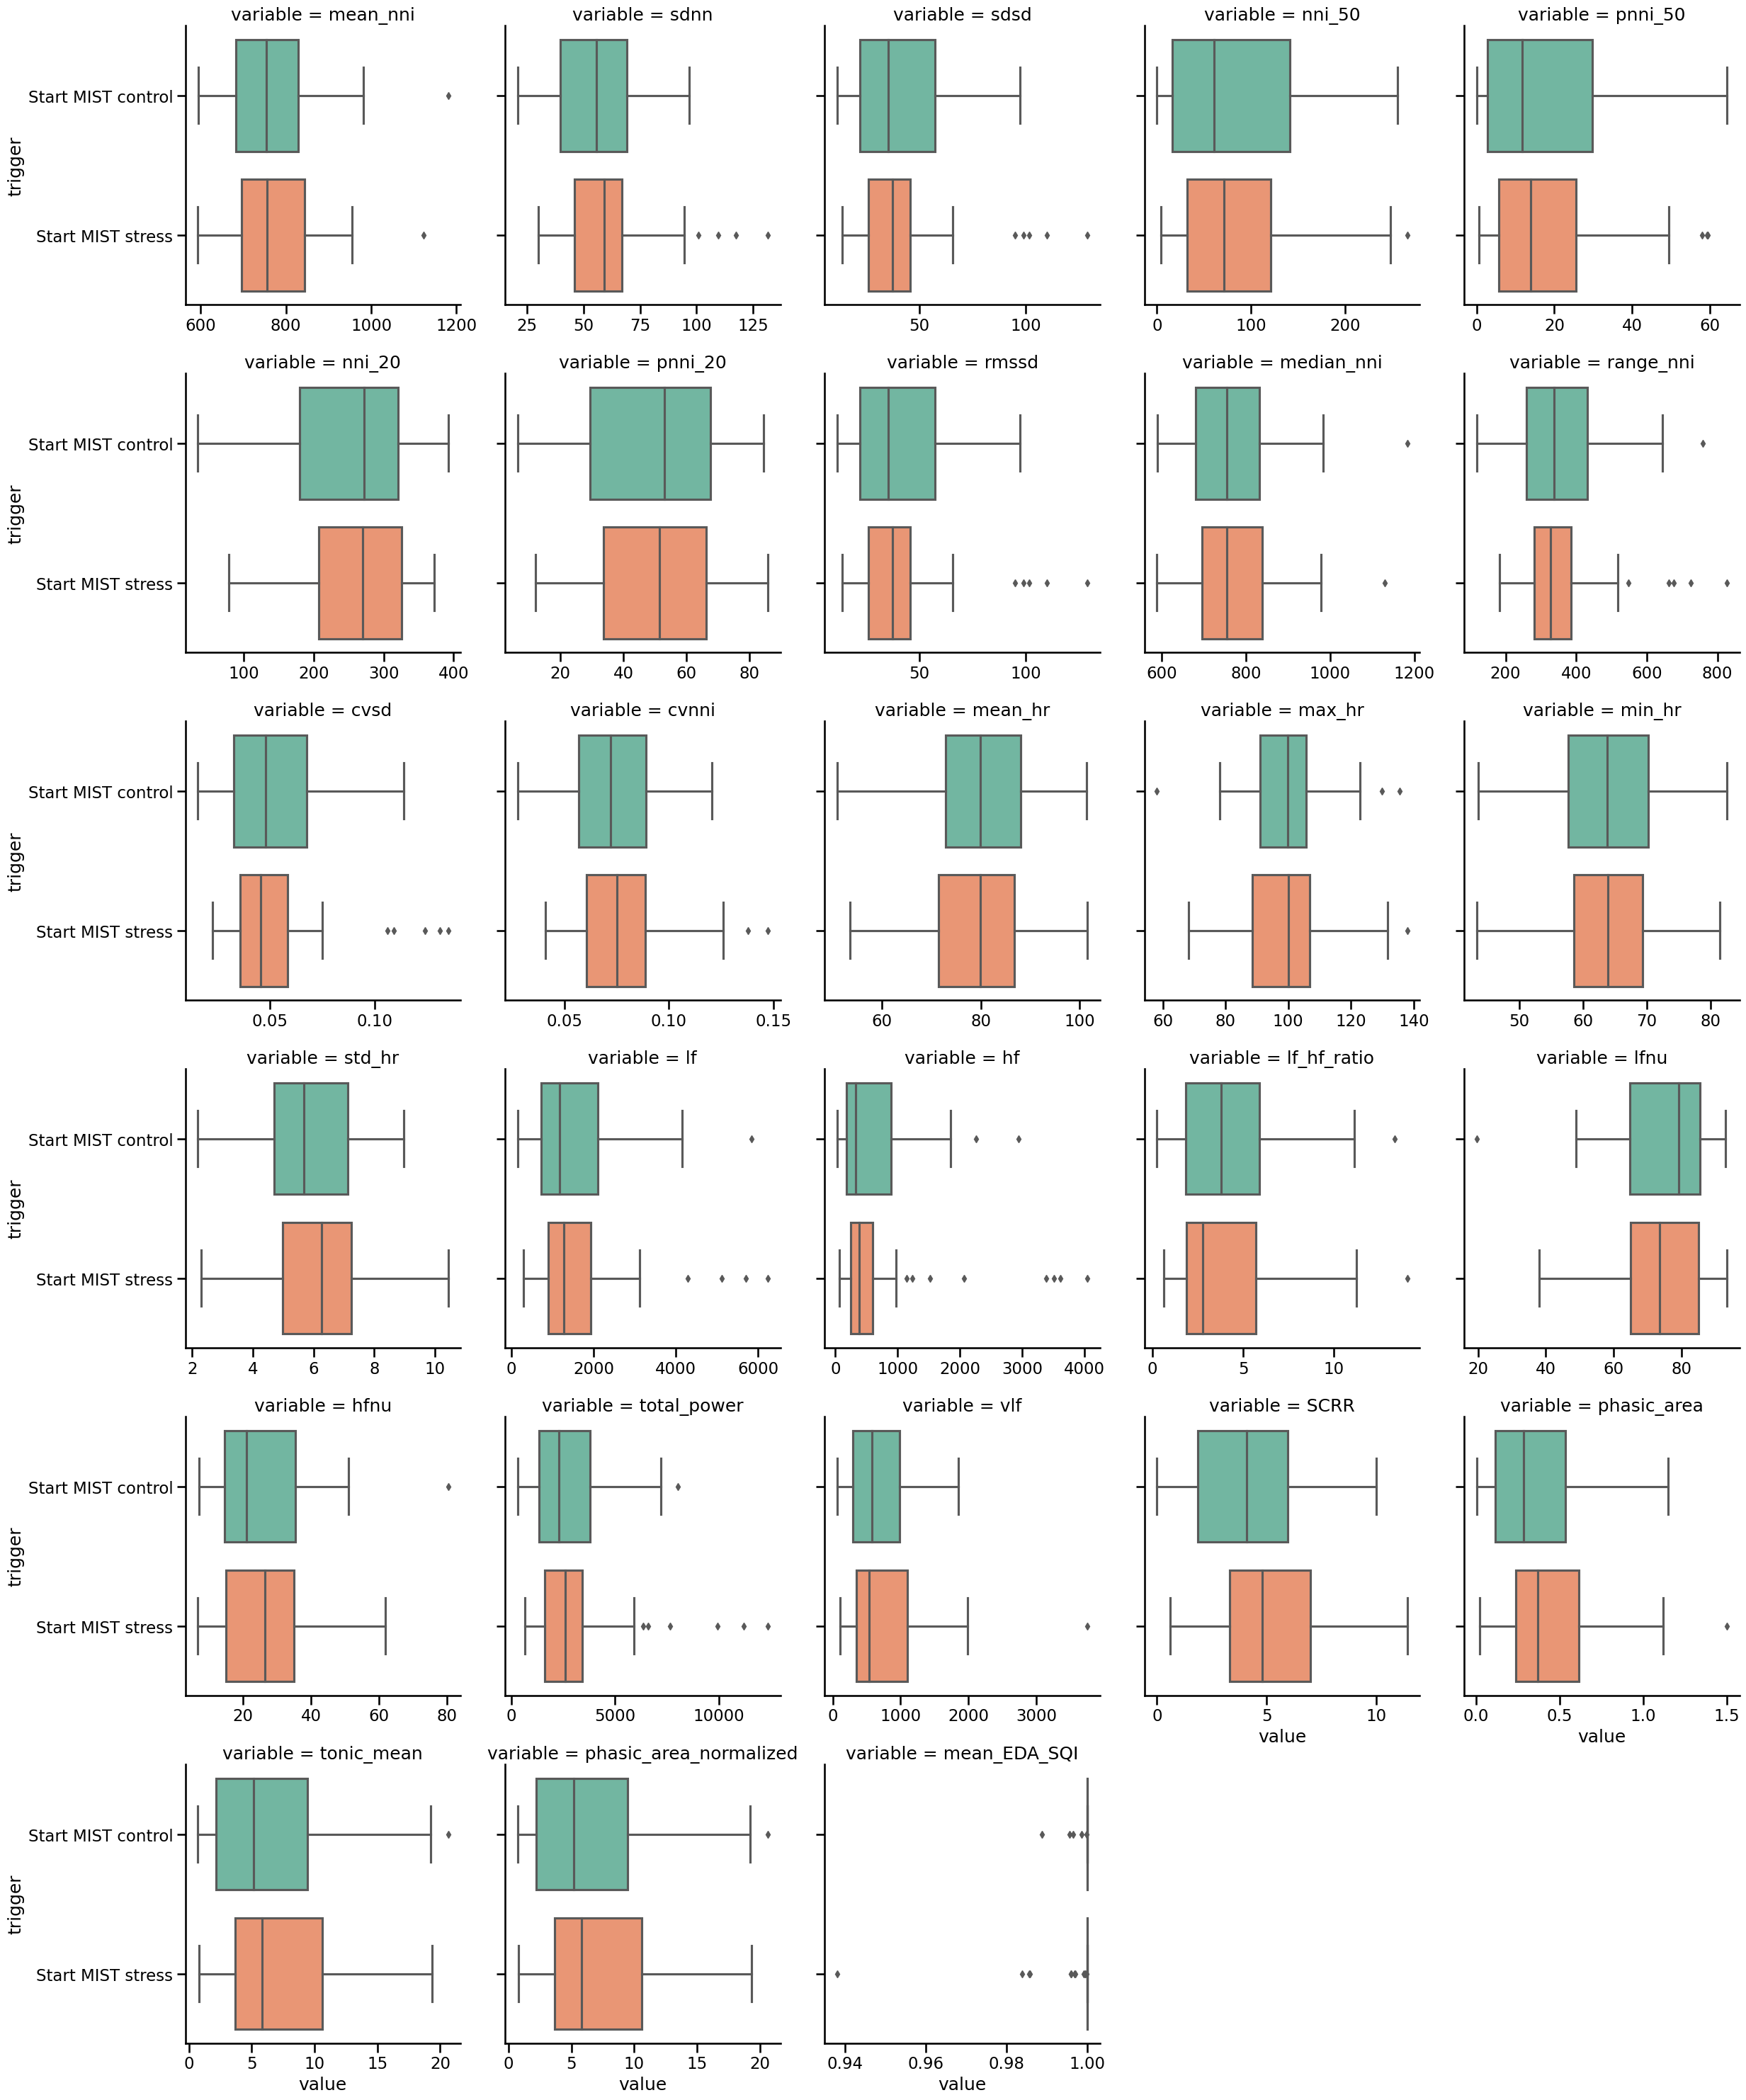

In [12]:
sns.catplot(
    data=df_feat_tot[
        df_feat_tot.trigger.isin(["Start MIST control", "Start MIST stress"])
    ].melt(
        id_vars=[
            "t_start",
            "t_end",
            "patient_id",
            "condition",
            "trigger",
            "duration",
            "duration_s",
        ]
    ),
    kind="box",
    x="value",
    y="trigger",
    aspect=1,
    col="variable",
    col_wrap=5,
    palette="Set2",
    sharex=False,
)


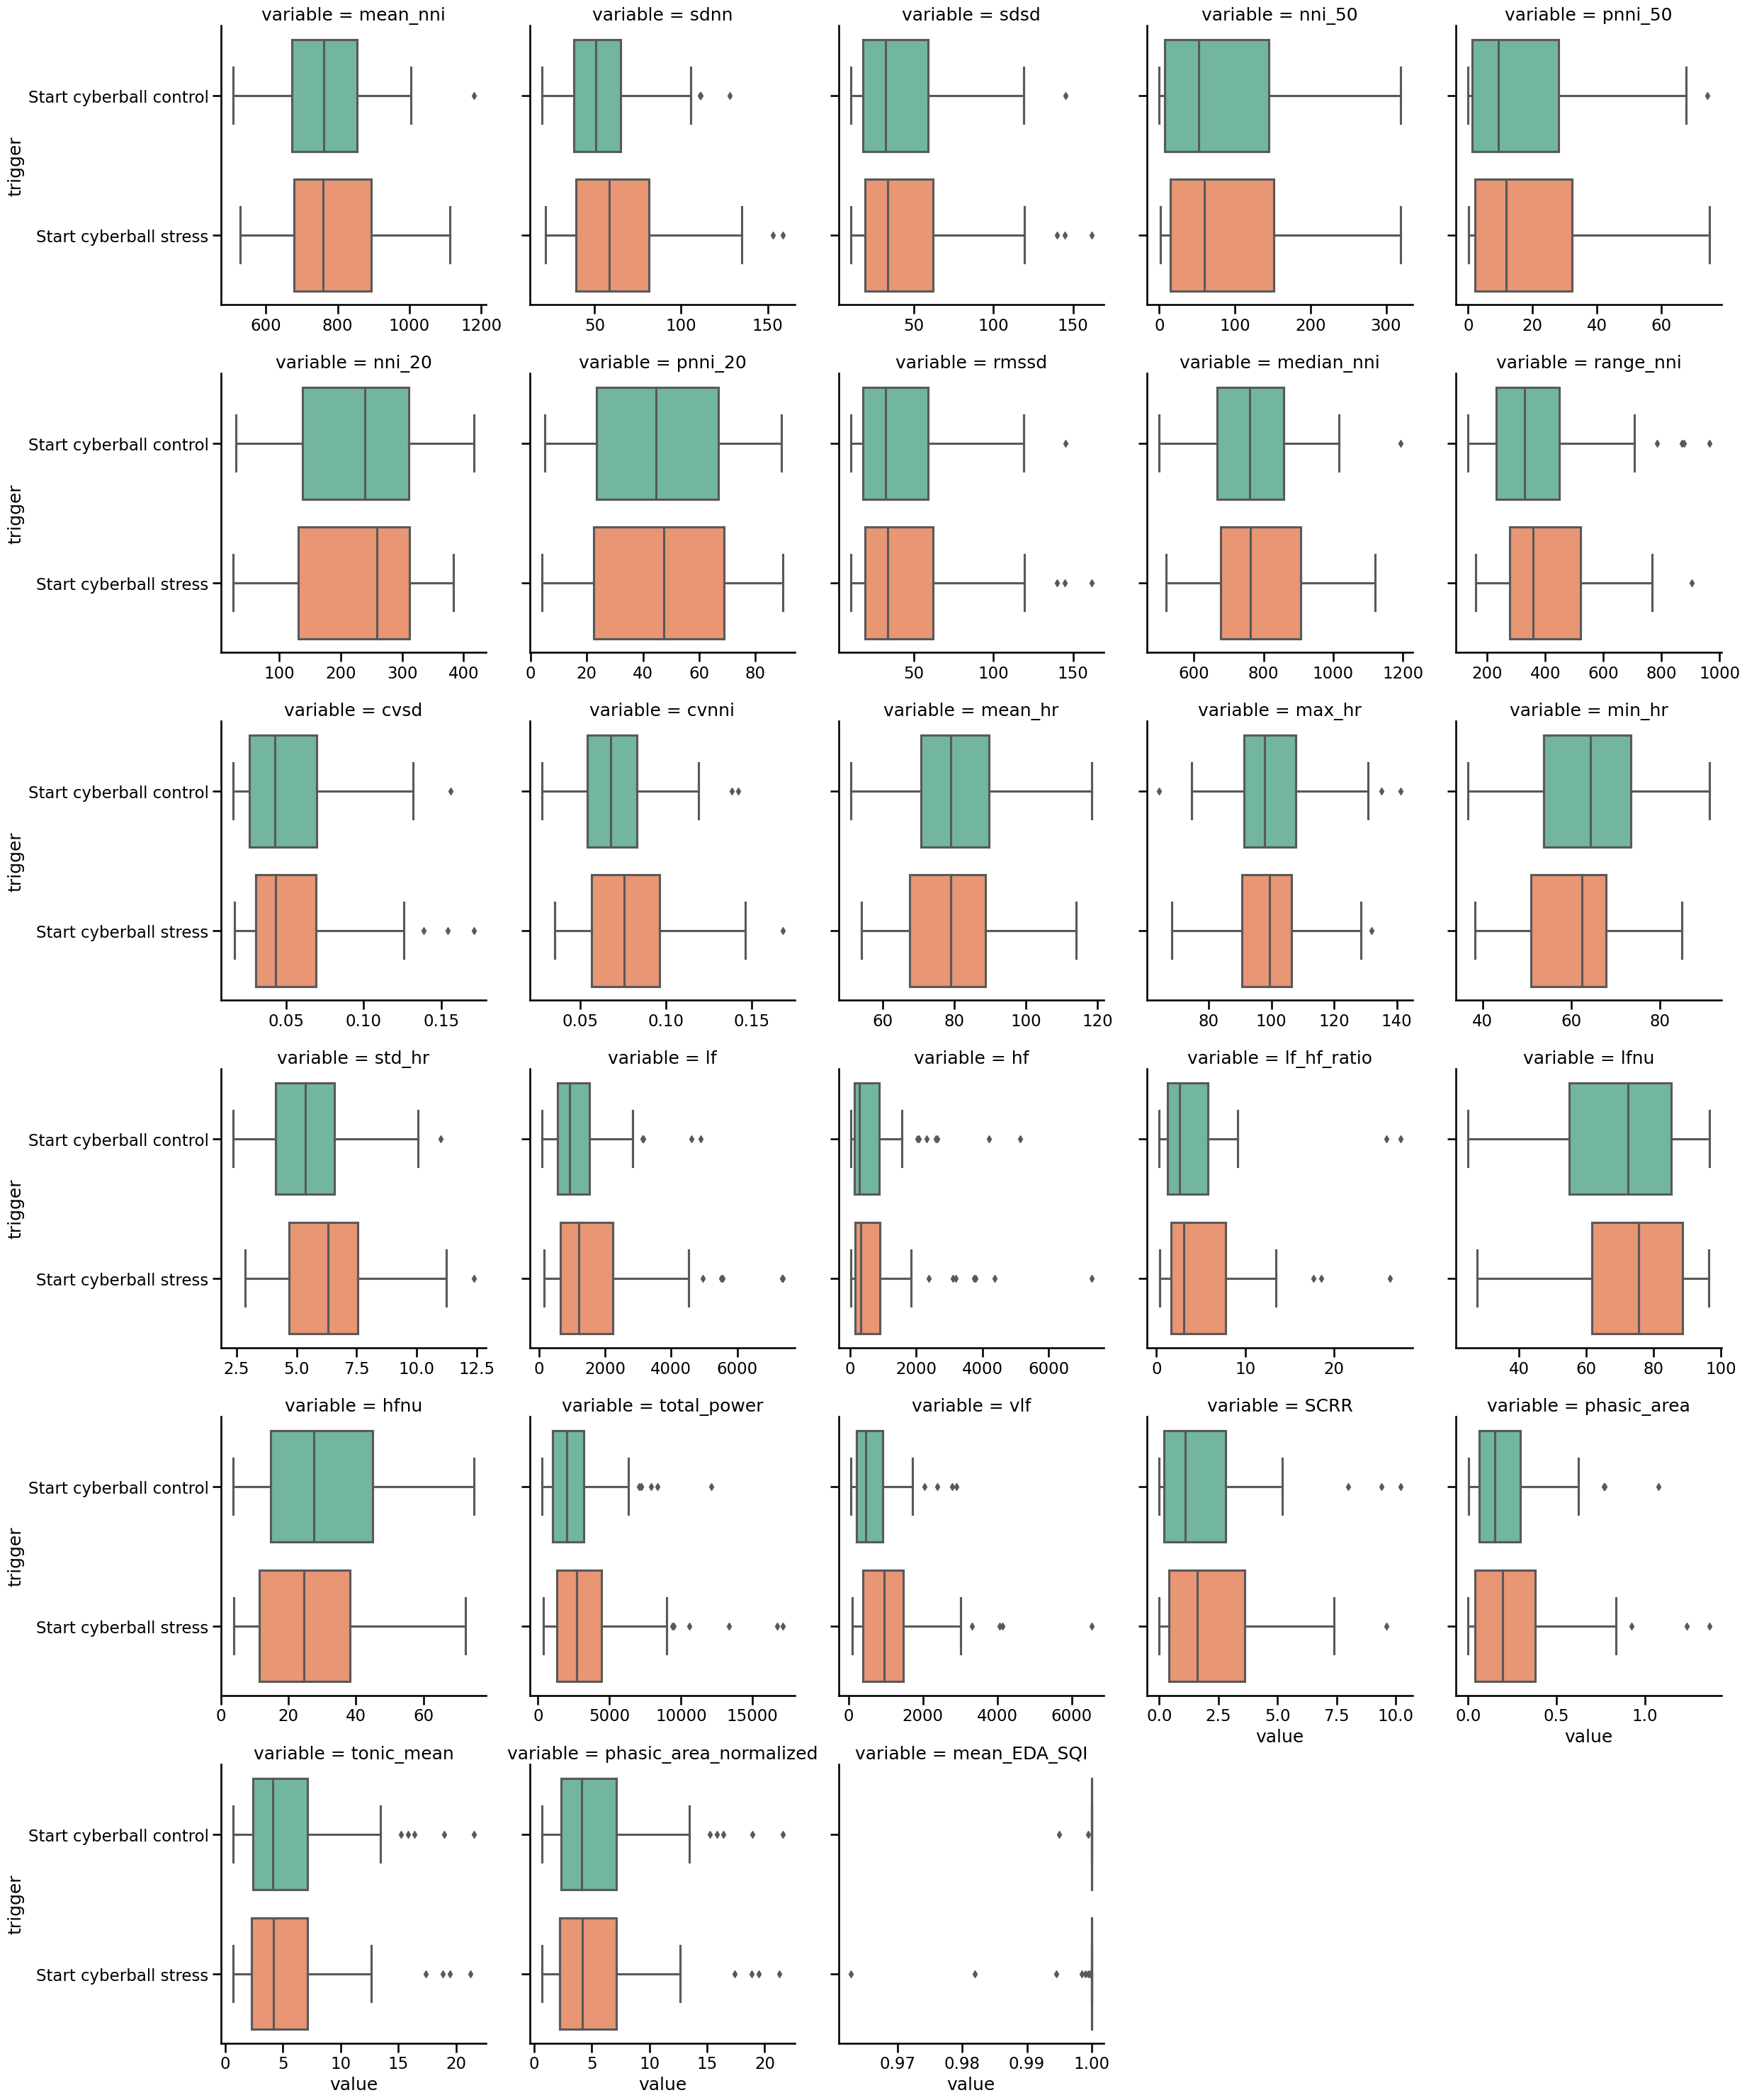

In [14]:
sns.catplot(
    data=df_feat_tot[
        df_feat_tot.trigger.isin(["Start cyberball control", "Start cyberball stress"])
    ].melt(
        id_vars=[
            "t_start",
            "t_end",
            "patient_id",
            "condition",
            "trigger",
            "duration",
            "duration_s",
        ]
    ),
    kind="box",
    x="value",
    y="trigger",
    aspect=1,
    col="variable",
    col_wrap=5,
    palette="Set2",
    sharex=False,
)


In [15]:
df_feat_tot.drop(columns=['duration']).to_parquet('df_feat_tot.parquet')